In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
from tqdm import tqdm
from transformers import pipeline
import os
import openai
import anthropic

anthropic_client = anthropic.Anthropic(api_key="<anthropic api key>")
openai_client = openai.OpenAI(api_key="openai api key")

# Load 50 test samples
splits = {'train': 'my_dataset/train.json', 'test': 'my_dataset/test.json'}
df = pd.read_json("hf://datasets/adesouza1/soap_notes/" + splits["test"])
test_df = df.sample(30, random_state=42)

# Few-shot examples (outside test set)
few_shot_examples = [
    {
        "patient_convo": "\nPhysician: Good morning, Zack. How are you feeling today?\n\nPatient: Hi, Doc. I've been feeling pretty lousy lately. I've got this constant pain in my right knee and left ankle that just won't go away. It's like a dull ache that's always there, no matter what I'm doing.\n\nPhysician: I see. Can you tell me more about the pain? Is it sharp, dull, throbbing? Does it feel like it's affecting your ability to move around?\n\nPatient: It's definitely dull and achy. It's not excruciating, but it's definitely noticeable. It's like there's pressure on my joints all the time. Yeah, it's definitely affecting my mobility. I've been avoiding stairs and stuff because it just hurts too much.\n\nPhysician: Okay, that helps. Have you noticed any swelling or redness in the affected areas?\n\nPatient: Not really. I mean, sometimes my knee will get a little puffy if I've been walking or standing for a while, but it's not like it's massively swollen or anything.\n\nPhysician: Got it. And how long have you been experiencing this pain?\n\nPatient: It started about six months ago. At first, it was just a little twinge every now and then, but it's gradually gotten worse over time.\n\nPhysician: I understand. Have you noticed any triggers that make the pain better or worse?\n\nPatient: Well, like I said, it gets worse when I'm walking or standing for a long time. But it also seems to get better if I'm sitting or lying down for a bit.\n\nPhysician: Okay, that's helpful. And have you tried any treatments or medications so far to help manage the pain?\n\nPatient: Yeah, I've been taking ibuprofen pretty regularly, but it only seems to help a little bit. And sometimes it makes my stomach feel weird, so I don't want to take too much of it.\n\nPhysician: I see. Well, based on what you've told me, it sounds like we're looking at a possible diagnosis of osteoarthritis. We'll need to do some further testing to confirm that, but in the meantime, I think we can start by prescribing you a different medication that might be more effective at managing your pain. I'd also like to refer you to physical therapy to help improve your mobility and reduce the strain on your joints. Does that sound good to you?\n\nPatient: Yeah, that sounds like a plan. Thanks, Doc.\n\nPhysician: You're welcome, Zack. We'll get you set up with a physical therapist and get that medication prescription sent over to your pharmacy. In the meantime, try to avoid any heavy lifting or bending, and see if you can take it easy on your joints for a bit. We'll follow up in a few weeks to see how you're doing and reassess from there. Sound good?\n\nPatient: Sounds good to me. Thanks again.",
        "soap_notes": "Subjective:\nZack Fields reports experiencing constant pain in his right knee and left ankle for the past six months. He describes the pain as a dull ache that is always present and affects his mobility, particularly when walking or standing for extended periods. He notes that the pain improves when he is sitting or lying down. Zack has been taking ibuprofen for pain relief, but it provides only minimal relief and occasionally causes stomach discomfort.\n\nObjective:\nDuring the examination, Zack appeared uncomfortable when moving his right knee and left ankle. There were no signs of swelling or redness in the affected joints. Zack's range of motion in both joints was limited due to pain. He is currently taking ibuprofen 600mg as needed for pain relief. Zack's mother expressed concerns about his mental health due to the impact of the pain on his daily activities.\n\nAssessment:\nBased on Zack's symptoms and history, the likely diagnosis is osteoarthritis in the right knee and left ankle. Further testing is needed to confirm the diagnosis. Zack's current pain management with ibuprofen is suboptimal, and he experiences occasional gastrointestinal side effects. Referral to physical therapy is recommended to improve mobility and reduce strain on the affected joints.\n\nPlan:\n1. Prescribe a different medication for pain management that may be more effective and have fewer gastrointestinal side effects.\n2. Refer Zack to physical therapy to address mobility issues and strengthen the affected joints.\n3. Advise Zack to avoid heavy lifting or bending and to take it easy on his joints.\n4. Follow up with Zack in a few weeks to assess his progress and adjust the treatment plan as needed."
    },
    {
        "patient_convo": "\n\nPhysician: Good morning, Mr. Diaz. How are you feeling today?\n\nPatient: Hi, Dr. Burns. I've been feeling pretty lousy lately. I've had this constant heartburn that doesn't seem to go away, even when I take my medication. And sometimes, I get this sharp pain in my stomach that makes me feel like I'm going to throw up.\n\nPhysician: I see. Have you noticed any other symptoms? Maybe some bloating or abdominal discomfort?\n\nPatient: Yeah, I do get bloated a lot, and sometimes I have this feeling of fullness that lasts for hours. And the abdominal pain can be pretty intense. It's like someone is stabbing me with a knife.\n\nPhysician: I understand. Have you had any changes in your bowel movements? Maybe some diarrhea or constipation?\n\nPatient: Well, I have had some diarrhea lately, but it's not always there. And sometimes, I feel like I can't go to the bathroom even when I need to. It's like my body is just not responding.\n\nPhysician: Okay, that's helpful. Have you noticed any other symptoms? Maybe some nausea or vomiting?\n\nPatient: Yes, I do get nauseous sometimes, especially when I eat certain foods. And I have vomited a few times, but it's not constant.\n\nPhysician: I see. Have you had any recent weight changes or loss of appetite?\n\nPatient: Well, I have lost a little bit of weight recently, but I think that's because I just don't feel like eating much. And sometimes, I get this feeling of being really tired all the time.\n\nPhysician: Okay, that's good to know. Have you noticed any triggers that make your symptoms worse? Maybe certain foods or stress?\n\nPatient: Yeah, I think spicy foods make my heartburn worse, and sometimes, I feel like stress does too. But it's hard to say for sure.\n\nPhysician: That's understandable. Have you had any recent travel or exposures to illness?\n\nPatient: No, nothing recent. I did go on a trip to Mexico a few months ago, but I don't think that's related.\n\nPhysician: Okay, that's good to know. I'm going to order some tests to help us better understand what's going on. We'll do an endoscopy to take a look at your esophagus and stomach, and we'll also do some blood tests to check for any infections or inflammation. In the meantime, I'd like you to start keeping a food diary to track any triggers that might be making your symptoms worse. Does that sound good to you?\n\nPatient: Yes, that sounds like a good plan. Thank you, Dr. Burns.\n\nPhysician: You're welcome, Mr. Diaz. We'll get to the bottom of this and figure out the best course of treatment for you.",
        "soap_notes": "Subjective:\nMr. Diaz reports feeling lousy lately with constant heartburn that persists despite medication. He also experiences sharp stomach pain, bloating, abdominal discomfort, intermittent diarrhea, nausea, vomiting, weight loss, loss of appetite, and fatigue. He notes that spicy foods and stress may exacerbate his symptoms.\n\nObjective:\nMr. Diaz appears fatigued during the appointment. He denies any recent travel or exposures to illness. Gastroenterologist recommends further evaluation with an endoscopy due to intermittent abdominal pain and bloating. Spouse notes fatigue and loss of appetite as additional symptoms to consider.\n\nAssessment:\nMr. Diaz presents with chronic GERD, hypertension, and gastrointestinal issues. Further evaluation with an endoscopy and blood tests is warranted to investigate his symptoms. A food diary will be initiated to track potential triggers.\n\nPlan:\nOrder endoscopy and blood tests to investigate symptoms. Initiate food diary to track triggers. Follow up with results to determine appropriate treatment plan. Encourage continued communication with care team for comprehensive care."
    }
]

def call_model(model_name, conversation):
    system_prompt = "\n\n".join([
        f"Patient-Doctor Conversation:\n{ex['patient_convo']}\n\nSOAP Note:\n{ex['soap_notes']}" 
        for ex in few_shot_examples
    ]) + "\n\nYou are a medical assistant that generates structured SOAP notes based on the conversation."

    user_prompt = f"Patient-Doctor Conversation:\n{conversation}\n\nSOAP Note:"

    claude_prompt = (
        "You are a helpful medical assistant that generates structured SOAP notes from doctor-patient conversations.\n\n"
        "Here are two examples:\n\n"
        "Example 1:\n"
        "Patient-Doctor Conversation:\n"
        f"{few_shot_examples[0]['patient_convo']}\n\n"
        "SOAP Note:\n"
        f"{few_shot_examples[0]['soap_notes']}\n\n"
        "Example 2:\n"
        "Patient-Doctor Conversation:\n"
        f"{few_shot_examples[1]['patient_convo']}\n\n"
        "SOAP Note:\n"
        f"{few_shot_examples[1]['soap_notes']}\n\n"
        "---\n\n"
        "Now generate a SOAP note for the following conversation:\n\n"
        f"Patient-Doctor Conversation:\n{conversation}\n\nSOAP Note:"
    )


    if model_name.startswith("gpt"):
        # Choose the right model
        gpt_model = "gpt-3.5-turbo" if model_name == "gpt-3.5" else "gpt-4"

        response = openai_client.chat.completions.create(
            model=gpt_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.3,
            max_tokens=500
        )
        return response.choices[0].message.content
    
    elif model_name == "claude-sonnet-3.5":
        full_prompt = anthropic.HUMAN_PROMPT + "\n" + system_prompt + "\n" + user_prompt + anthropic.AI_PROMPT
        response = anthropic_client.messages.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=1024,
            messages=[
                {"role": "user", "content": claude_prompt}
            ]
        )
        return response.content[0].text

    else:
        raise ValueError(f"Unsupported model: {model_name}")


In [38]:
example_convo = "Doctor: How have you been sleeping?\nPatient: Not very well. I wake up several times at night."
print(call_model("gpt-3.5", example_convo))
print(call_model("gpt-4", example_convo))
print(call_model("claude-sonnet-3.5", example_convo))

Subjective:
The patient reports experiencing poor sleep quality, waking up several times at night.

Objective:
Further assessment needed to determine the underlying cause of the patient's sleep disturbances.

Assessment:
Patient presents with complaints of fragmented sleep patterns.

Plan:
Refer the patient to a sleep specialist for further evaluation and management of sleep disturbances. Encourage the patient to maintain a sleep diary to track patterns and potential triggers. Follow up after consultation with the sleep specialist for further management.
Subjective: 
The patient reports difficulty sleeping, stating that they wake up several times throughout the night.

Objective: 
During the consultation, the patient appeared tired and fatigued.

Assessment: 
The patient is experiencing interrupted sleep, which may be due to various causes such as insomnia, sleep apnea, or stress.

Plan: 
Further evaluation is needed to determine the cause of the sleep disruption. Recommend maintaining

In [40]:
# Generate predictions
models = ["gpt-3.5", "gpt-4.0", "claude-sonnet-3.5"]
results = {model: [] for model in models}

for model in models:
    print(f"Generating outputs for {model}...")
    for convo in tqdm(test_df["patient_convo"]):
        output = call_model(model, convo)
        results[model].append(output)

Generating outputs for gpt-3.5...


100%|██████████| 30/30 [01:37<00:00,  3.26s/it]


Generating outputs for gpt-4.0...


100%|██████████| 30/30 [07:22<00:00, 14.73s/it]


Generating outputs for claude-sonnet-3.5...


100%|██████████| 30/30 [03:56<00:00,  7.89s/it]


In [43]:
import pandas as pd

output_df = pd.DataFrame({
    "patient_convo": test_df["patient_convo"],
    "gpt_3.5_output": results["gpt-3.5"],
    "gpt_4_output": results["gpt-4.0"],
    "claude_output": results["claude-sonnet-3.5"],
    "soap_notes": test_df["soap_notes"]
})

# Save to CSV
output_df.to_csv("model_outputs_with_predictions.csv", index=False)
print("Saved predictions to 'model_outputs_with_predictions.csv'")

Saved predictions to 'model_outputs_with_predictions.csv'


In [6]:
import pandas as pd
import evaluate
from bert_score import score as bert_score

# Load predictions
eval_df = pd.read_csv("/kaggle/input/soap-note-gen-gpt3-5-4-claude/model_outputs_with_predictions.csv")

# Ground truth
references = eval_df["soap_notes"].tolist()

# Metric loaders
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Models to evaluate
model_columns = {
    "gpt-3.5": "gpt_3.5_output",
    "gpt-4.0": "gpt_4_output",
    "claude-sonnet-3.5": "claude_output"
}

evaluation_scores = {}

for model_name, col in model_columns.items():
    print(f"\n🔍 Evaluating {model_name}...")
    preds = eval_df[col].tolist()

    # ROUGE
    rouge_result = rouge.compute(predictions=preds, references=references, use_stemmer=True)
    rouge_scores = rouge_result

    # BLEU
    bleu_result = bleu.compute(
        predictions=preds,
        references=[[ref] for ref in references]  # Correct format: list of list of strings
    )

    # BERTScore
    P, R, F1 = bert_score(preds, references, lang="en", verbose=True)

    # Store results
    evaluation_scores[model_name] = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BLEU": bleu_result["bleu"],
        "BERTScore": F1.mean().item()
    }

# Print summary
print("\n Evaluation Results:")
for model, scores in evaluation_scores.items():
    print(f"\n{model}:")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")


🔍 Evaluating gpt-3.5...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 110.61 seconds, 0.27 sentences/sec

🔍 Evaluating gpt-4.0...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 111.47 seconds, 0.27 sentences/sec

🔍 Evaluating claude-sonnet-3.5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 123.71 seconds, 0.24 sentences/sec

 Evaluation Results:

gpt-3.5:
ROUGE-1: 0.6829
ROUGE-2: 0.4008
ROUGE-L: 0.4837
BLEU: 0.3822
BERTScore: 0.9279

gpt-4.0:
ROUGE-1: 0.6247
ROUGE-2: 0.3308
ROUGE-L: 0.4251
BLEU: 0.3095
BERTScore: 0.9190

claude-sonnet-3.5:
ROUGE-1: 0.5423
ROUGE-2: 0.2170
ROUGE-L: 0.3273
BLEU: 0.1671
BERTScore: 0.8825


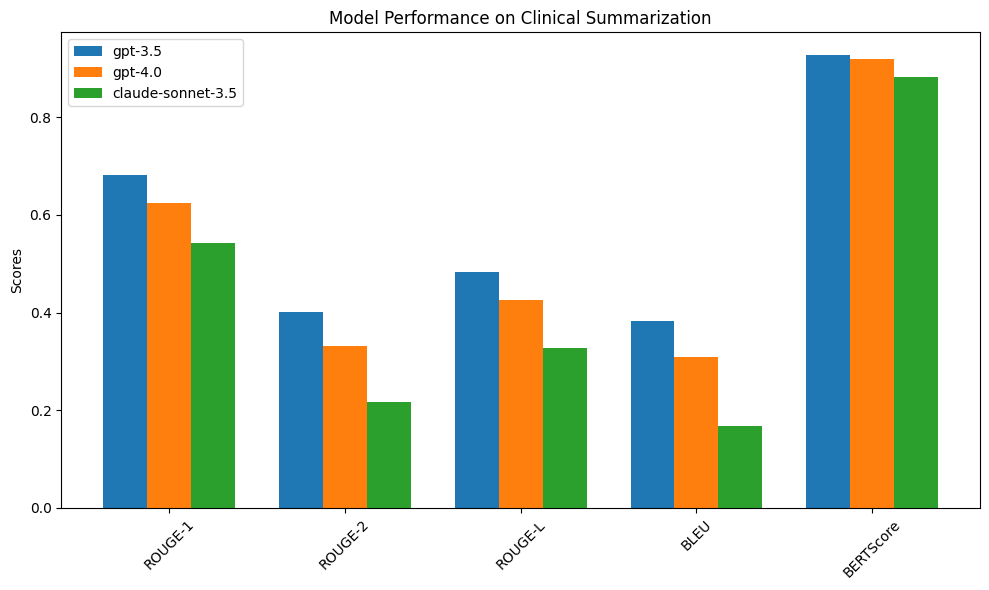

In [9]:
# === Plotting ===
import numpy as np
import matplotlib.pyplot as plt

models = ["gpt-3.5", "gpt-4.0", "claude-sonnet-3.5"]
labels = list(evaluation_scores[models[0]].keys())
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    scores = [evaluation_scores[model][label] for label in labels]
    ax.bar(x + i * width, scores, width, label=model)

ax.set_ylabel("Scores")
ax.set_title("Model Performance on Clinical Summarization")
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()